# Extrasensory perception

* 싸이그래머 / 인지모델링 : 파트 2 - 베이지안 인지모델링 [1]
* 김무성

# Contents

* 13.1 Evidence for optional stopping
* 13.2 Evidence for differences in ability
* 13.3 Evidence for the impact of extraversion

<img src="figures/cap13.1.png" width=600 />

# 13.1 Evidence for optional stopping

<img src="figures/cap13.2.png" width=600 />

## JAGS code

#### Correlation 1.txt

In [1]:
# Pearson Correlation
correlation_1_s = "
model{
  # Data
  for (i in 1:n){
    x[i,1:2] ~ dmnorm(mu[],TI[,])
  }
  # Priors
  mu[1] ~ dnorm(0,.001)
  mu[2] ~ dnorm(0,.001)
  lambda[1] ~ dgamma(.001,.001)
  lambda[2] ~ dgamma(.001,.001)
  r ~ dunif(-1,1)
  # Reparameterization
  sigma[1] <- 1/sqrt(lambda[1])
  sigma[2] <- 1/sqrt(lambda[2])
  T[1,1] <- 1/lambda[1]
  T[1,2] <- r*sigma[1]*sigma[2]
  T[2,1] <- r*sigma[1]*sigma[2]
  T[2,2] <- 1/lambda[2]
  TI[1:2,1:2] <- inverse(T[1:2,1:2])
}
"

#### OptionalStopping_jags.R

In [2]:
library(R2jags)

Loading required package: rjags
Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot



In [3]:
# Sample size N and effect size E in the Bem experiments
N <- c(100,150,97,99,100,150,200,100,50)
E <- c(0.25, 0.20, 0.25, 0.20, 0.22, 0.15, 0.09, 0.19, 0.42)

x <- matrix(cbind(N,E),nrow=9) 
n <- nrow(x) # number of experiments

data <- list("x", "n") # to be passed on to JAGS

In [4]:
myinits <-	list(
  list(r = 0, mu = c(0,0), lambda = c(1,1)))

In [5]:
# parameters to be monitored:	
parameters <- c("r", "mu", "sigma")

In [6]:
# The following command calls JAGS with specific options.
# For a detailed description see the R2jags documentation.
samples <- jags(data, inits=myinits, parameters,
	 			textConnection(correlation_1_s), #model.file ="Correlation_1.txt",
	 			n.chains=1, n.iter=5000, n.burnin=5, n.thin=1)

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 29

Initializing model



In [123]:
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

r <- samples$BUGSoutput$sims.list$r

In [124]:
#============ BFs based on logspline fit ===========================
library(polspline) # this package can be installed from within R
fit.posterior <- logspline(r)

In [125]:
# 95% confidence interval:
x0 <- qlogspline(0.025,fit.posterior)
x1 <- qlogspline(0.975,fit.posterior)

In [126]:
posterior     <- dlogspline(0, fit.posterior) # this gives the pdf at point r = 0
prior         <- .5                           # height of prior at r = 0
BF10          <- prior/posterior
BF10
# 21.99

[1] 23.30755

In [127]:
# Compare to approximation Jeffreys (1961), pp. 289-292:
BF10.J.approx <- function(n, r)
{ 
  BF10 <- 1/(((2*n-1)/pi)^.5 * (1-r^2)^(.5*(n-3)))
  return(BF10)
}
BF10.J.approx(n=length(N)-1, r=cor(N,E)) #16.20

[1] 16.19579

In [128]:
# Compare to exact solution Jeffreys (numerical integration):
BF10.J.exact <- function(n, r)
{
  integrand <- function(rho) {((1-rho^2)^(n/2)) / ((1-rho*r)^(n-.5))}
  BF10      <- integrate(integrand, lower=-1, upper=1)$value/2
  return(BF10)
}
BF10.J.exact(n=length(N)-1, r=cor(N,E)) #21.54
#====================================================================

[1] 21.53765

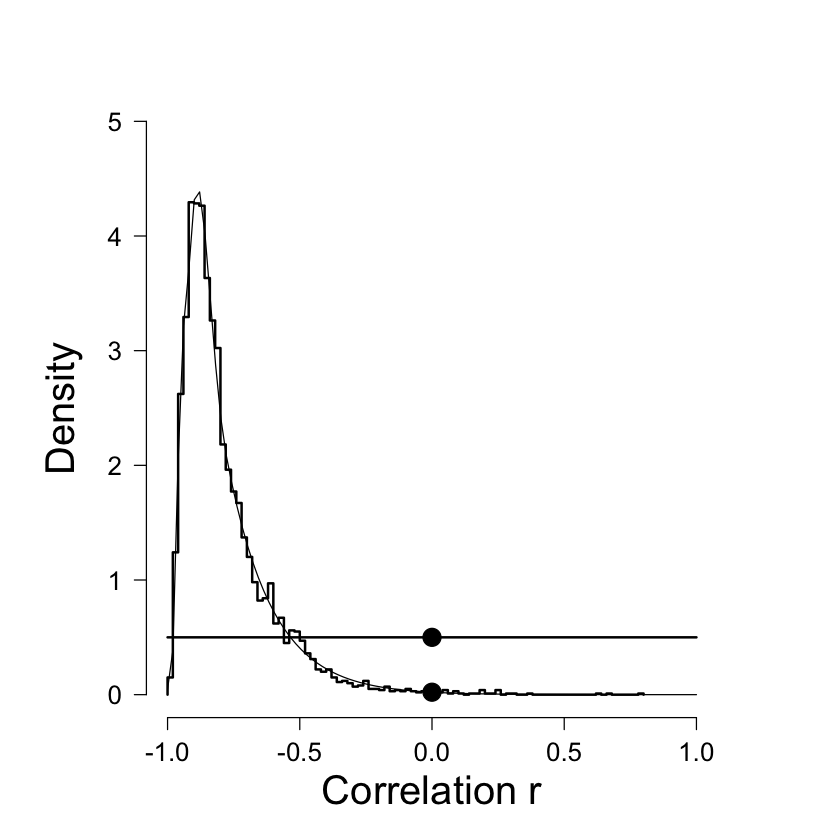

In [129]:
#============ Plot Prior and Posterior  ===========================
par(cex.main = 1.5, mar = c(5, 6, 4, 5) + 0.1, mgp = c(3.5, 1, 0), cex.lab = 1.5,
    font.lab = 2, cex.axis = 1.3, bty = "n", las=1)
xlow  <- -1
xhigh <- 1
yhigh <- 5
Nbreaks <- 80

y <- hist(r, Nbreaks, plot=F)
plot(c(y$breaks, max(y$breaks)), c(0,y$density,0), type="S", lwd=2, lty=1,
     xlim=c(xlow,xhigh), ylim=c(0,yhigh), xlab=" ", ylab=" ", main = " ", axes=F) 
axis(1)
axis(2)
mtext("Correlation r", side=1, line = 2.8, cex=2)
mtext("Density", side=2, line = 2.8, cex=2, las=0)
#now bring in log spline density estimation:
par(new=T)
plot(fit.posterior, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lty=1, lwd=1, axes=F)
points(0, dlogspline(0, fit.posterior),pch=19, cex=2)
# plot the prior:
lines(c(-1,1),c(0.5,0.5),lwd=2)
points(0, .5, pch=19, cex=2)
###########################################################################

<img src="figures/cap13.3.png" width=600 />

# 13.2 Evidence for differences in ability

<img src="figures/cap13.4.png" width=600 />

<img src="figures/cap13.5.png" width=600 />

## JAGS code

#### Ability.txt

In [130]:
# Ability Correlation for ESP Replication
ability_s = "
model{
  # Data
  for (i in 1:nsubjs){
    thetap[i,1:2] ~ dmnorm(mu[],TI[,])
    for (j in 1:2){
      theta[i,j] <- phi(thetap[i,j])
      k[i,j] ~ dbin(theta[i,j],ntrials)
    }
  }
  # Priors
  mu[1] ~ dnorm(0,.001)
  mu[2] ~ dnorm(0,.001)
  lambda[1] ~ dgamma(.001,.001)
  lambda[2] ~ dgamma(.001,.001)
  r ~ dunif(0,1)
  # Reparameterization
  sigma[1] <- 1/sqrt(lambda[1])
  sigma[2] <- 1/sqrt(lambda[2])
  T[1,1] <- 1/lambda[1]
  T[1,2] <- r*sigma[1]*sigma[2]
  T[2,1] <- r*sigma[1]*sigma[2]
  T[2,2] <- 1/lambda[2]
  TI[1:2,1:2] <- inverse(T[1:2,1:2])
}
"

#### Ability_jags.R

In [131]:
# Proportion correct on erotic pictures, block 1 and block 2:
prc1.ero <- c(0.6000000, 0.5333333, 0.6000000, 0.6000000, 0.4666667, 
             0.6666667, 0.6666667, 0.4000000, 0.6000000, 0.6000000,
             0.4666667, 0.6666667, 0.4666667, 0.6000000, 0.3333333,
             0.4000000, 0.4000000, 0.2666667, 0.3333333, 0.5333333,
             0.6666667, 0.5333333, 0.6000000, 0.4000000, 0.4666667, 
             0.7333333, 0.6666667, 0.6000000, 0.6666667, 0.5333333,
             0.5333333, 0.6666667, 0.4666667, 0.3333333, 0.4000000,
             0.5333333, 0.4000000, 0.4000000, 0.3333333, 0.4666667,
             0.4000000, 0.4666667, 0.4666667, 0.5333333, 0.3333333,
             0.7333333, 0.2666667, 0.6000000, 0.5333333, 0.4666667,
             0.4000000, 0.5333333, 0.6666667, 0.4666667, 0.5333333,
             0.5333333, 0.4666667, 0.4000000, 0.4666667, 0.6666667,
             0.4666667, 0.3333333, 0.3333333, 0.3333333, 0.4000000,
             0.4000000, 0.6000000, 0.4666667, 0.3333333, 0.3333333,
             0.6666667, 0.5333333, 0.3333333, 0.6000000, 0.4666667,
             0.4666667, 0.4000000, 0.3333333, 0.4666667, 0.5333333,
             0.8000000, 0.4000000, 0.5333333, 0.5333333, 0.6666667,
             0.6666667, 0.6666667, 0.6000000, 0.6000000, 0.5333333,
             0.3333333, 0.4666667, 0.6666667, 0.5333333, 0.3333333,
             0.3333333, 0.2666667, 0.2666667, 0.4666667, 0.6666667)

prc2.ero <- c(0.3333333, 0.6000000, 0.5333333, 0.2666667, 0.6666667,
             0.5333333, 0.6666667, 0.4666667, 0.4666667, 0.6666667,
             0.4000000, 0.6666667, 0.2666667, 0.4000000, 0.4666667,
             0.3333333, 0.5333333, 0.6000000, 0.3333333, 0.4000000,
             0.4666667, 0.4666667, 0.6000000, 0.5333333, 0.5333333,
             0.6000000, 0.5333333, 0.6666667, 0.6000000, 0.2666667,
             0.4666667, 0.4000000, 0.6000000, 0.5333333, 0.4000000,
             0.4666667, 0.5333333, 0.3333333, 0.4000000, 0.4666667,
             0.8000000, 0.6000000, 0.2000000, 0.6000000, 0.4000000,
             0.4000000, 0.2666667, 0.2666667, 0.6000000, 0.4000000,
             0.4000000, 0.4000000, 0.4000000, 0.4000000, 0.6666667,
             0.7333333, 0.5333333, 0.5333333, 0.3333333, 0.6000000,
             0.5333333, 0.5333333, 0.4666667, 0.5333333, 0.4666667,
             0.5333333, 0.4000000, 0.4000000, 0.4666667, 0.6000000,
             0.6000000, 0.6000000, 0.4666667, 0.6000000, 0.6666667,
             0.5333333, 0.4666667, 0.6000000, 0.2000000, 0.5333333,
             0.4666667, 0.4000000, 0.5333333, 0.5333333, 0.5333333,
             0.5333333, 0.6000000, 0.6666667, 0.4000000, 0.4000000,
             0.5333333, 0.8000000, 0.6000000, 0.4000000, 0.2000000,
             0.6000000, 0.6666667, 0.4666667, 0.4666667, 0.4666667)             

x <- matrix(cbind(prc1.ero,prc2.ero),nrow=100) 
n <- nrow(x) # number of participants

data <- list("x", "n") # to be passed on to JAGS

In [132]:
myinits <- list(
  list(r = 0, mu = c(0,0), lambda = c(1,1)))

In [133]:
# parameters to be monitored:	
parameters <- c("r", "mu", "sigma")

In [134]:
# The following command calls JAGS with specific options.
# For a detailed description see the R2jags documentation.
samples <- jags(data, inits=myinits, parameters,
	 			textConnection(correlation_1_s), # "Abillity.txt"를 모델 파일로 써야 하지 않나? model.file ="Correlation_1.txt",
	 			n.chains=1, n.iter=5000, n.burnin=5, n.thin=1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 120

Initializing model



In [135]:
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

r <- samples$BUGSoutput$sims.list$r

In [136]:
#Method 1, select only positive r's:
r.pos <- r[which(r>0)]

In [137]:
#============ BFs based on logspline fit ===========================
library(polspline) # this package can be installed from within R
fit.posterior <- logspline(r.pos, lbound=0, ubound=1)

In [138]:
# 95% confidence interval:
x0 <- qlogspline(0.025,fit.posterior)
x1 <- qlogspline(0.975,fit.posterior)

In [139]:
posterior     <- dlogspline(0, fit.posterior) # this gives the pdf at point r = 0
prior         <- 1                            # height of prior at r = 0
BF10.M1       <- prior/posterior
BF10.M1 # 0.36

[1] 0.4914258

In [140]:
#Method 2, renormalization:
fit.posterior <- logspline(r)
posterior     <- dlogspline(0, fit.posterior) # this gives the pdf at point delta = 0
# renormalize:
area            <- sum(posterior > 0)/length(posterior)
posterior.OR.M2 <- posterior/area
BF10.M2         <- prior/posterior.OR.M2
BF10.M2 # 0.49

[1] 0.5275912

In [141]:
# Compare to exact solution Jeffreys (numerical integration):
BF10.J.exact.positive <- function(n, r)
{
  integrand <- function(rho) {((1-rho^2)^(n/2)) / ((1-rho*r)^(n-.5))}
  BF10      <- integrate(integrand, lower=0, upper=1)$value
  return(BF10)
}
BF10.J.exact.positive(n=length(prc1.ero)-1, r=cor(prc1.ero,prc2.ero)) # 0.46
#====================================================================

[1] 0.4561174

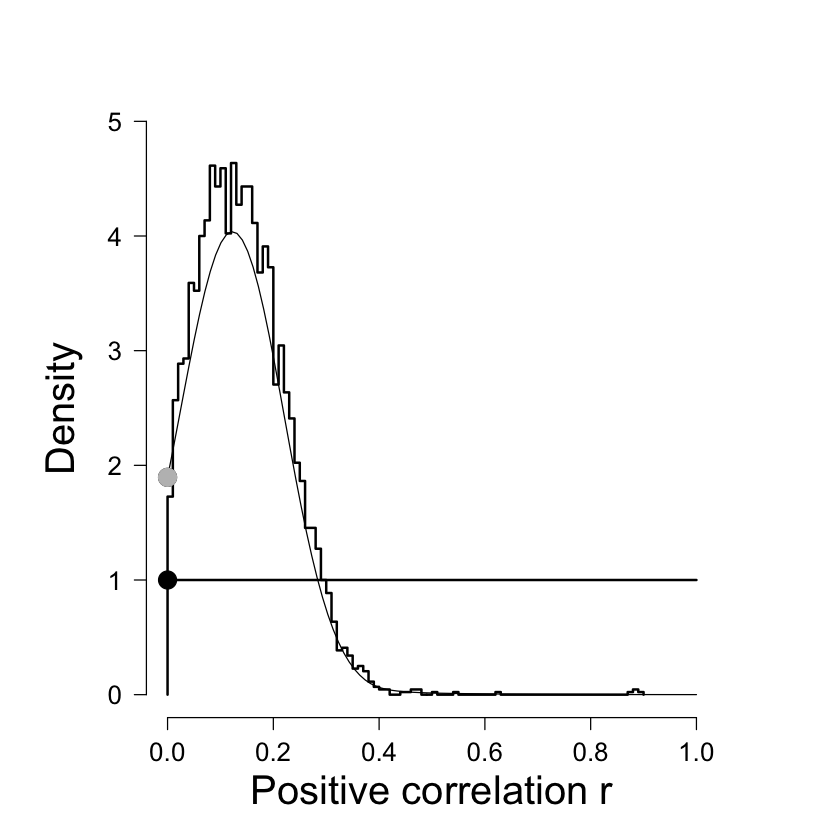

In [142]:
#============ Plot Prior and Posterior  ===========================
par(cex.main = 1.5, mar = c(5, 6, 4, 5) + 0.1, mgp = c(3.5, 1, 0), cex.lab = 1.5,
    font.lab = 2, cex.axis = 1.3, bty = "n", las=1)
xlow  <- 0
xhigh <- 1
yhigh <- 5
Nbreaks <- 80
y <- hist(r.pos, Nbreaks, prob=T, border="white", ylim=c(0,yhigh), xlim=c(xlow,xhigh), lwd=2, lty=1, 
         ylab=" ", xlab=" ", main=" ", axes=F) 
#white makes the original histogram -- with unwanted vertical lines -- invisible
lines(c(y$breaks, max(y$breaks)), c(0,y$density,0), type="S", lwd=2, lty=1) 
axis(1)
axis(2)
mtext("Positive correlation r", side=1, line = 2.8, cex=2)
mtext("Density", side=2, line = 2.8, cex=2, las=0)
#now bring in log spline density estimation:
par(new=T)
plot(fit.posterior, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lty=1, lwd=1, axes=F)
points(0, dlogspline(0, fit.posterior),pch=19, cex=2)
points(0, posterior.OR.M2, pch=19, cex=2, col="grey")
# plot the prior:
lines(c(0,1),c(1,1),lwd=2)
points(0, 1, pch=19, cex=2)
###########################################################################

<img src="figures/cap13.6.png" width=600 />

## Stan code

In [143]:
library(rstan)

In [144]:
model <- "
// Pearson Correlation
data { 
  int<lower=0> n;
  vector[2] x[n];
}
parameters {
  vector[2] mu;
  vector<lower=0>[2] lambda;
  real<lower=-1,upper=1> r;
} 
transformed parameters {
  vector<lower=0>[2] sigma;
  cov_matrix[2] T;

  // Reparameterization
  sigma[1] <- inv_sqrt(lambda[1]);
  sigma[2] <- inv_sqrt(lambda[2]);
  
  T[1,1] <- square(sigma[1]);
  T[1,2] <- r * sigma[1] * sigma[2];
  T[2,1] <- r * sigma[1] * sigma[2];
  T[2,2] <- square(sigma[2]);
}
model {
  // Priors
  mu ~ normal(0, inv_sqrt(.001));
  lambda ~ gamma(.001, .001);
  
  // Data
  x ~ multi_normal(mu, T);
}"

In [145]:
# Proportion correct on erotic pictures, block 1 and block 2:
prc1.ero <- c(0.6000000, 0.5333333, 0.6000000, 0.6000000, 0.4666667, 
              0.6666667, 0.6666667, 0.4000000, 0.6000000, 0.6000000,
              0.4666667, 0.6666667, 0.4666667, 0.6000000, 0.3333333,
              0.4000000, 0.4000000, 0.2666667, 0.3333333, 0.5333333,
              0.6666667, 0.5333333, 0.6000000, 0.4000000, 0.4666667, 
              0.7333333, 0.6666667, 0.6000000, 0.6666667, 0.5333333,
              0.5333333, 0.6666667, 0.4666667, 0.3333333, 0.4000000,
              0.5333333, 0.4000000, 0.4000000, 0.3333333, 0.4666667,
              0.4000000, 0.4666667, 0.4666667, 0.5333333, 0.3333333,
              0.7333333, 0.2666667, 0.6000000, 0.5333333, 0.4666667,
              0.4000000, 0.5333333, 0.6666667, 0.4666667, 0.5333333,
              0.5333333, 0.4666667, 0.4000000, 0.4666667, 0.6666667,
              0.4666667, 0.3333333, 0.3333333, 0.3333333, 0.4000000,
              0.4000000, 0.6000000, 0.4666667, 0.3333333, 0.3333333,
              0.6666667, 0.5333333, 0.3333333, 0.6000000, 0.4666667,
              0.4666667, 0.4000000, 0.3333333, 0.4666667, 0.5333333,
              0.8000000, 0.4000000, 0.5333333, 0.5333333, 0.6666667,
              0.6666667, 0.6666667, 0.6000000, 0.6000000, 0.5333333,
              0.3333333, 0.4666667, 0.6666667, 0.5333333, 0.3333333,
              0.3333333, 0.2666667, 0.2666667, 0.4666667, 0.6666667)

prc2.ero <- c(0.3333333, 0.6000000, 0.5333333, 0.2666667, 0.6666667,
              0.5333333, 0.6666667, 0.4666667, 0.4666667, 0.6666667,
              0.4000000, 0.6666667, 0.2666667, 0.4000000, 0.4666667,
              0.3333333, 0.5333333, 0.6000000, 0.3333333, 0.4000000,
              0.4666667, 0.4666667, 0.6000000, 0.5333333, 0.5333333,
              0.6000000, 0.5333333, 0.6666667, 0.6000000, 0.2666667,
              0.4666667, 0.4000000, 0.6000000, 0.5333333, 0.4000000,
              0.4666667, 0.5333333, 0.3333333, 0.4000000, 0.4666667,
              0.8000000, 0.6000000, 0.2000000, 0.6000000, 0.4000000,
              0.4000000, 0.2666667, 0.2666667, 0.6000000, 0.4000000,
              0.4000000, 0.4000000, 0.4000000, 0.4000000, 0.6666667,
              0.7333333, 0.5333333, 0.5333333, 0.3333333, 0.6000000,
              0.5333333, 0.5333333, 0.4666667, 0.5333333, 0.4666667,
              0.5333333, 0.4000000, 0.4000000, 0.4666667, 0.6000000,
              0.6000000, 0.6000000, 0.4666667, 0.6000000, 0.6666667,
              0.5333333, 0.4666667, 0.6000000, 0.2000000, 0.5333333,
              0.4666667, 0.4000000, 0.5333333, 0.5333333, 0.5333333,
              0.5333333, 0.6000000, 0.6666667, 0.4000000, 0.4000000,
              0.5333333, 0.8000000, 0.6000000, 0.4000000, 0.2000000,
              0.6000000, 0.6666667, 0.4666667, 0.4666667, 0.4666667)             

x <- matrix(cbind(prc1.ero, prc2.ero), nrow=100) 
n <- nrow(x) # number of participants

data <- list(x=x, n=n) # To be passed on to Stan

myinits <- list(
  list(r=0, mu=c(0, 0), lambda=c(1, 1)))

parameters <- c("r", "mu", "sigma")  # Parameters to be monitored

In [146]:
# The following command calls Stan with specific options.
# For a detailed description type "?rstan".
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=2000, 
                chains=1, 
                thin=1,
                # warmup=100,  # Stands for burn-in; Default = iter/2
                # seed=123  # Setting seed; Default is random seed
)


TRANSLATING MODEL 'model' FROM Stan CODE TO C++ CODE NOW.
COMPILING THE C++ CODE FOR MODEL 'model' NOW.
In file included from file77d64151ea1f.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:17:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev.hpp:5:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev/chainable.hpp:87:17: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
    static void set_zero_all_adjoints() {
                ^
In file included from file77d64151ea1f.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:21:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rsta

In [147]:
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

r <- extract(samples)$r

In [148]:
#Method 1, select only positive r's:
r.pos <- r[which(r>0)]

In [149]:
#============ BFs based on logspline fit ===========================
library(polspline) # this package can be installed from within R
fit.posterior <- logspline(r.pos, lbound=0, ubound=1)

# 95% confidence interval:
x0 <- qlogspline(0.025,fit.posterior)
x1 <- qlogspline(0.975,fit.posterior)

posterior    <- dlogspline(0, fit.posterior) # this gives the pdf at point r = 0
prior        <- 1                            # height of prior at r = 0
BF10.M1      <- prior/posterior
BF10.M1 # 0.36

[1] 0.4238034

In [150]:
#Method 2, renormalization:
fit.posterior <- logspline(r)
posterior <- dlogspline(0, fit.posterior) # this gives the pdf at point delta = 0
# renormalize:
area            <- sum(posterior > 0)/length(posterior)
posterior.OR.M2 <- posterior/area
BF10.M2         <- prior/posterior.OR.M2
BF10.M2 # 0.49

[1] 0.5545494

In [151]:
# Compare to exact solution Jeffreys (numerical integration):
BF10.J.exact.positive <- function(n, r)
{
  integrand <- function(rho) {((1-rho^2)^(n/2)) / ((1-rho*r)^(n-.5))}
  BF10      <- integrate(integrand, lower=0, upper=1)$value
  return(BF10)
}
BF10.J.exact.positive(n=length(prc1.ero)-1, r=cor(prc1.ero,prc2.ero)) # 0.46
#====================================================================

[1] 0.4561174

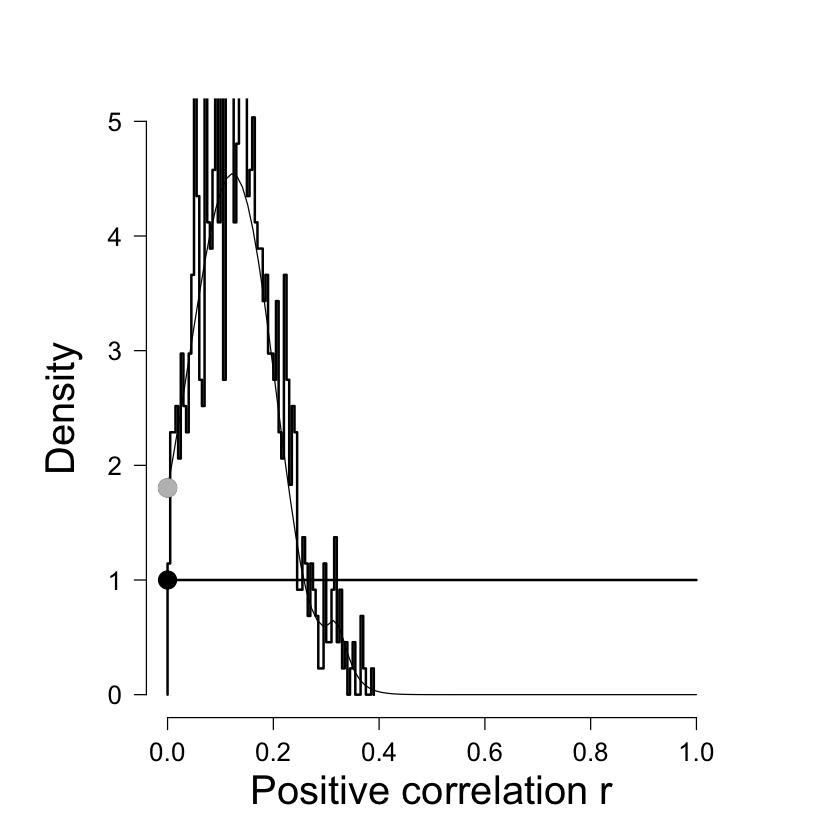

In [152]:
#============ Plot Prior and Posterior  ===========================
par(cex.main = 1.5, mar = c(5, 6, 4, 5) + 0.1, mgp = c(3.5, 1, 0), cex.lab = 1.5,
    font.lab = 2, cex.axis = 1.3, bty = "n", las=1)
xlow  <- 0
xhigh <- 1
yhigh <- 5
Nbreaks <- 80
y <- hist(r.pos, Nbreaks, prob=T, border="white", ylim=c(0,yhigh),
         xlim=c(xlow,xhigh), lwd=2, lty=1, ylab=" ", xlab=" ", main=" ", axes=F) 
#white makes the original histogram -- with unwanted vertical lines -- invisible
lines(c(y$breaks, max(y$breaks)), c(0,y$density,0), type="S", lwd=2, lty=1) 
axis(1)
axis(2)
mtext("Positive correlation r", side=1, line = 2.8, cex=2)
mtext("Density", side=2, line = 2.8, cex=2, las=0)
#now bring in log spline density estimation:
par(new=T)
plot(fit.posterior, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lty=1, lwd=1, axes=F)
points(0, dlogspline(0, fit.posterior),pch=19, cex=2)
points(0, posterior.OR.M2, pch=19, cex=2, col="grey")
# plot the prior:
lines(c(0,1),c(1,1),lwd=2)
points(0, 1, pch=19, cex=2)
###########################################################################

# 13.3 Evidence for the impact of extraversion

<img src="figures/cap13.7.png" width=600 />

<img src="figures/cap13.8.png" width=600 />

## JAGS Code

#### Extraversion.txt 

In [42]:
# Extraversion Correlation for ESP Replication
extraversion_s = "
model{
  # Data
  for (i in 1:nsubjs){
    thetap[i,1:2] ~ dmnorm(mu[],TI[,])
    theta[i,1] <- phi(thetap[i,1])
    k[i] ~ dbin(theta[i,1],ntrials)
    theta[i,2] <- 100*phi(thetap[i,2])
    x[i] ~ dnorm(theta[i,2],lambdax)
  }
  # Priors
  mu[1] ~ dnorm(0,.001)
  mu[2] ~ dnorm(0,.001)
  lambda[1] ~ dgamma(.001,.001)
  lambda[2] ~ dgamma(.001,.001)
  r ~ dunif(-1,1)
  # Reparameterization
  sigma[1] <- 1/sqrt(lambda[1])
  sigma[2] <- 1/sqrt(lambda[2])
  T[1,1] <- 1/lambda[1]
  T[1,2] <- r*sigma[1]*sigma[2]
  T[2,1] <- r*sigma[1]*sigma[2]
  T[2,2] <- 1/lambda[2]
  TI[1:2,1:2] <- inverse(T[1:2,1:2])
}
"

#### Extraversion_jags.R

In [43]:
k <- c(36, 32, 36, 36, 28, 40, 40, 24, 36, 36, 28, 40, 28, 
       36, 20, 24, 24, 16, 20, 32, 40, 32, 36, 24, 28, 44,
       40, 36, 40, 32, 32, 40, 28, 20, 24, 32, 24, 24, 20, 
       28, 24, 28, 28, 32, 20, 44, 16, 36, 32, 28, 24, 32,
       40, 28, 32, 32, 28, 24, 28, 40, 28, 20, 20, 20, 24,
       24, 36, 28, 20, 20, 40, 32, 20, 36, 28, 28, 24, 20,
       28, 32, 48, 24, 32, 32, 40, 40, 40, 36, 36, 32, 20,
       28, 40, 32, 20, 20, 16, 16, 28, 40)
       
x <- c(50, 80, 79, 56, 50, 80, 53, 84, 74, 67, 50, 45, 62, 
       65, 71, 71, 68, 63, 67, 58, 72, 73, 63, 54, 63, 70, 
       81, 71, 66, 74, 70, 84, 66, 73, 78, 64, 54, 74, 62, 
       71, 70, 79, 66, 64, 62, 63, 60, 56, 72, 72, 79, 67, 
       46, 67, 77, 55, 63, 44, 84, 65, 41, 62, 64, 51, 46,
       53, 26, 67, 73, 39, 62, 59, 75, 65, 60, 69, 63, 69, 
       55, 63, 86, 70, 67, 54, 80, 71, 71, 55, 57, 41, 56, 
       78, 58, 76, 54, 50, 61, 60, 32, 67)
       
nsubjs  <- length(k)
ntrials <- 60
sigmax  <- 3
lambdax <- 1/(sigmax^2)

data <- c("k", "x", "lambdax", "ntrials", "nsubjs") # to be passed on to JAGS

In [44]:
myinits <-	list(
  list(r = -0.1, mu = c(0.1,-0.1), lambda = c(.5,1)),
  list(r = 0.1, mu = c(0.2,-0.2), lambda = c(1,.5))
  )

In [45]:
# parameters to be monitored:	
parameters <- c("r", "mu", "sigma", "theta")

In [46]:
# The following command calls JAGS with specific options.
# For a detailed description see the R2jags documentation.
samples <- jags(data, inits=myinits, parameters,
	 			textConnection(extraversion_s), #model.file ="Extraversion.txt",
	 			n.chains=2, n.iter=10000, n.burnin=5000, n.thin=1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 823

Initializing model



In [47]:
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

r <- samples$BUGSoutput$sims.list$r

In [48]:
#============ BFs based on logspline fit ===========================
library(polspline) # this package can be installed from within R
fit.posterior <- logspline(r)

In [49]:
# 95% confidence interval:
x0 <- qlogspline(0.025,fit.posterior)
x1 <- qlogspline(0.975,fit.posterior)

In [50]:
posterior     <- dlogspline(0, fit.posterior) # this gives the pdf at point r = 0
prior         <- .5                           # height of prior at r = 0
BF10          <- prior/posterior
BF10
# 0.37

[1] 0.3674104

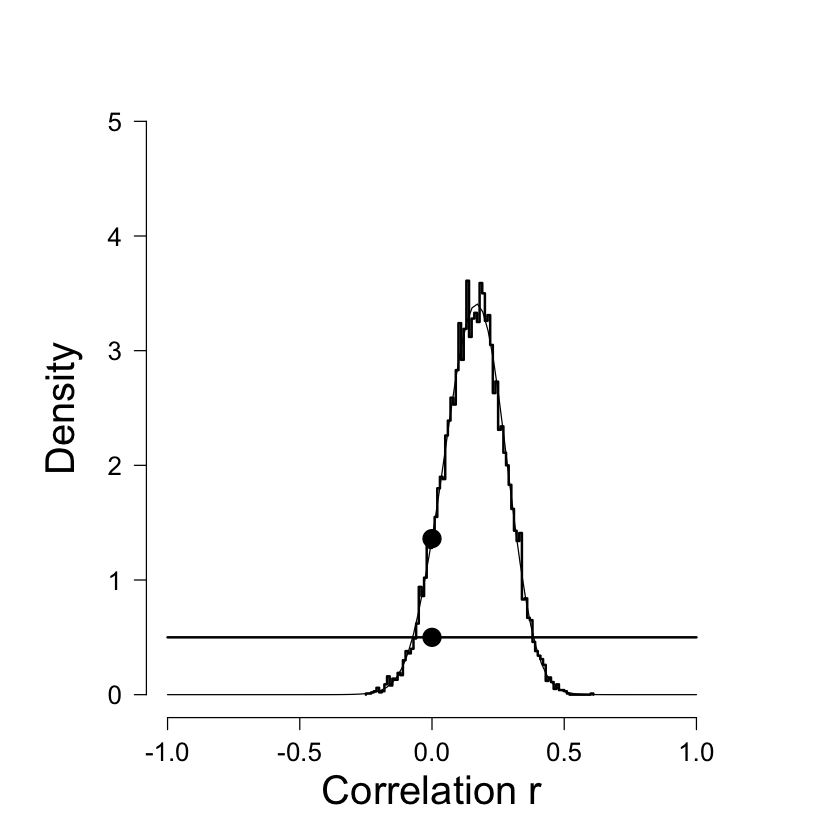

In [51]:
#============ Plot Prior and Posterior  ===========================
par(cex.main = 1.5, mar = c(5, 6, 4, 5) + 0.1, mgp = c(3.5, 1, 0), cex.lab = 1.5,
    font.lab = 2, cex.axis = 1.3, bty = "n", las=1)
xlow  <- -1
xhigh <- 1
yhigh <- 5
Nbreaks <- 80

y <- hist(r, Nbreaks, plot=F)
plot(c(y$breaks, max(y$breaks)), c(0,y$density,0), type="S", lwd=2, lty=1,
     xlim=c(xlow,xhigh), ylim=c(0,yhigh), xlab=" ", ylab=" ", main = " ", axes=F) 
axis(1)
axis(2)
mtext("Correlation r", side=1, line = 2.8, cex=2)
mtext("Density", side=2, line = 2.8, cex=2, las=0)
#now bring in log spline density estimation:
par(new=T)
plot(fit.posterior, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lty=1, lwd=1, axes=F)
points(0, dlogspline(0, fit.posterior),pch=19, cex=2)
# plot the prior:
lines(c(-1,1),c(0.5,0.5),lwd=2)
points(0, .5, pch=19, cex=2)
###########################################################################

<img src="figures/cap13.9.png" width=600 />

# 참고자료 

* [1] Bayesian Cognitive Modeling: A Practical Course - http://www.amazon.com/Bayesian-Cognitive-Modeling-Practical-Course/dp/1107603579/
* [2] codes(winbugs, jags) - http://bayesmodels.com/
* [3] codes(stan) - https://github.com/stan-dev/example-models/tree/master/Bayesian_Cognitive_Modeling
* [4] Dr. Daryl Bem - https://en.wikipedia.org/wiki/Daryl_Bem